In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
df = pd.read_csv('./data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [52]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values  
print(f'X shape {X.shape}, y shape {y.shape} fraud cases {y.sum()}')

X shape (284807, 28), y shape (284807,) fraud cases 492


### Model Evaluation / Selection

####  LogisticRegresion

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score
# set class weight baise on fraud cases
params = {'class_weight':[{0:1, 1:v} for v in np.linspace(1, 20, 30)]}
mod = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=params,
    scoring={
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)},
    refit='f1_score', 
    cv=10,
    n_jobs=-1)
mod.fit(X,y)
print(mod.cv_results_)

{'mean_fit_time': array([5.38776665, 5.32729912, 4.56771514, 4.98575816, 5.4753442 ,
       5.26125031, 5.06848226, 4.78004181, 4.47812138, 5.30880389,
       4.59707971, 4.49254837, 4.16011589, 4.36925888, 4.23175285,
       4.079899  , 3.81999071, 4.22015507, 4.59365957, 3.74617956,
       4.12454209, 4.44863999, 3.98413732, 4.26087816, 4.25387154,
       4.23276429, 4.41899679, 4.30131652, 4.10470607, 3.67011704]), 'std_fit_time': array([0.36273544, 0.36000276, 0.4714148 , 0.59468422, 1.41369297,
       0.70245043, 0.6902903 , 0.5679998 , 0.50852681, 0.81080598,
       0.60906143, 0.53361624, 0.37219448, 0.32965378, 0.31414998,
       0.27164683, 0.50011601, 0.49668915, 0.55998989, 0.25750103,
       0.47035696, 0.24494968, 0.67786578, 0.52269351, 1.12742637,
       0.58476347, 0.5789492 , 0.84845257, 0.66626113, 0.66127494]), 'mean_score_time': array([0.06597111, 0.05681298, 0.05398216, 0.07421608, 0.07812657,
       0.0741457 , 0.08218739, 0.06102736, 0.07049789, 0.08018651,
     

In [54]:
print(f' best estimator: {mod.best_estimator_}, best score {mod.best_score_} best param {mod.best_params_}')

 best estimator: LogisticRegression(class_weight={0: 1, 1: 4.931034482758621}, max_iter=1000), best score 0.7762773042978889 best param {'class_weight': {0: 1, 1: 4.931034482758621}}


In [55]:
pred = mod.predict(X)
print(f'f1_score {f1_score(y, pred)}')

f1_score 0.801635991820041


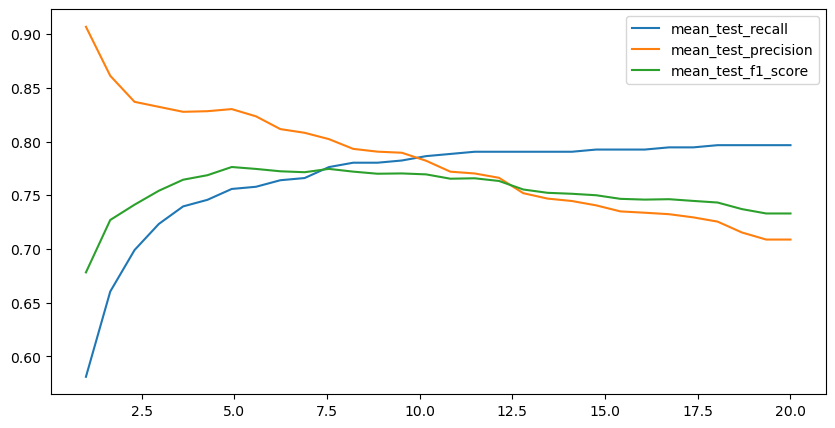

In [56]:
plt.figure(figsize=(10,5))
df = pd.DataFrame(mod.cv_results_)

for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_f1_score']:
    plt.plot(
        [_[1] for _ in df['param_class_weight']],
        df[score],
        label=score)
plt.legend()

### Outlier Detection Model
### IsolationForest
Fraud being an outlier we are going to use a model that detects outlier: its a rare event but out of extraodinary

In [57]:
from sklearn.ensemble import IsolationForest

def f1_score_(estimator, X, y_true, sample_weight=None):
    y_pred = estimator.predict(X)
    precision = precision_score(y_true, np.where(y_pred==-1, 1, 0))
    recall =  recall_score(y_true, np.where(y_pred==-1, 1, 0))
    return 2 * (precision * recall) / (precision + recall)

mod = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination':np.linspace(0.01, 0.02, 10)},
    scoring={'f1_score': f1_score_},
    refit='f1_score', 
    cv=10,
    n_jobs=-1)
mod.fit(X,y)
print(mod.cv_results_)

In [ ]:
print(f' best estimator: {mod.best_estimator_}, best score {mod.best_score_} best param {mod.best_params_}')

 best estimator: LogisticRegression(class_weight={0: 1, 1: 4.931034482758621}, max_iter=1000), best score 0.7762773042978889 best param {'class_weight': {0: 1, 1: 4.931034482758621}}


In [ ]:
pred = mod.predict(X)
print(f'f1_score {f1_score(y, pred)}')

f1_score 0.801635991820041


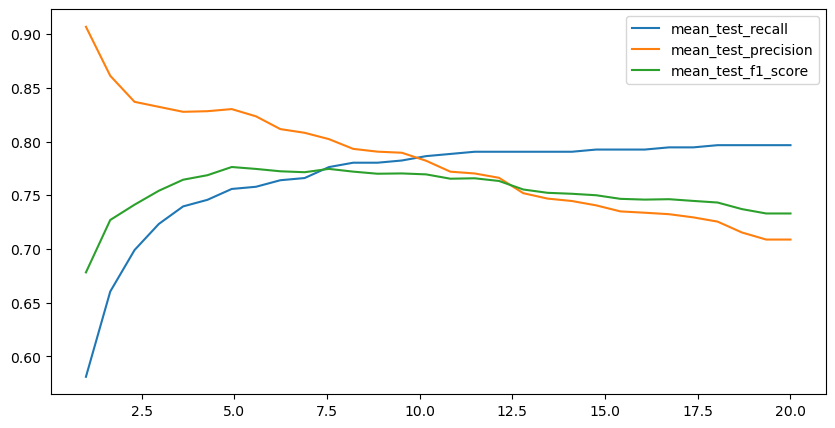

In [ ]:
plt.figure(figsize=(10,5))
df = pd.DataFrame(mod.cv_results_)

for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_f1_score']:
    plt.plot(
        [_[1] for _ in df['param_class_weight']],
        df[score],
        label=score)
plt.legend()